# mKeima Assay Analysis - FKBP-ULK1 tethering experiment
## Library imports and notebook settings
- Version 2024-07-04
- Made for mkeima version 0.6.0

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import mkeima
import mkeima.plot

In [2]:
plt.rcParams["pdf.fonttype"] = 42
mkeima.plot.set_dpi(90)

## Parameters

### Define input and output paths

In [3]:
experiment_directory = "../raw_data/FKBP-ULK1_tethering"
directory_structure = ["Experiment"]
summary_path = "../processed_data/summary_FKBP-ULK1_tethering.tsv"
figure_path = "../plots/summary_FKBP-ULK1_tethering.pdf"

### Define conditions and channels

In [4]:
channels = {
    "high_ph": "Violet610-H",
    "low_ph": "ECD-H",
    "gfp": "FITC-H",
}

condition_mapping = {
    "baf": "1",
    "rich": "2",
    "rapa1h": "3",
    "rapa2h": "4",
    "rapa4h": "5",
    "rapa6h": "6",
    "rapa24h": "7"
}
condition_order = ["1", "2", "3", "4", "5", "6", "7"]
reference_condition = "1"
scale_reference_condition = "7"
gfp_cutoff = 50000

# Specify a list of colors to use for the different conditions
mkeima.plot.ColorWheelDict.default_colors = [
    "#ced0d1", "#ced0d1", "#909295", "#909295", "#909295", "#909295", "#909295"
]

## Import and process flow cytometry data

In [5]:
data = mkeima.import_from_directory(experiment_directory, directory_structure)
data = mkeima.infer_setup_from_filename(data)

In [6]:
data.replace(condition_mapping, inplace=True)

In [7]:
mkeima.calculate_mkeima_ratio(
    data,
    high_ph=channels["high_ph"],
    low_ph=channels["low_ph"],
)

mkeima.calculate_mkeima_score(
    data,
    high_ph=channels["high_ph"],
    low_ph=channels["low_ph"],
    reference=reference_condition,
)

In [8]:
summary = mkeima.summarize(
    data[(data[channels["gfp"]] > gfp_cutoff)],
    group_by=["Condition", "Replicate"],
    on="mkeima ratio",
)
summary = mkeima.scale_to_reference(
    summary,
    on="Mean",
    reference=scale_reference_condition,
    min_reference=reference_condition,
    reference_range = (2, 100),
)

In [9]:
summary_outliers = mkeima.summarize_outliers(
    data[(data[channels["gfp"]] > gfp_cutoff)],
    reference="1",
    group_by=["Condition", "Replicate"],
    on="mkeima ratio",
)

## Generate QC plots

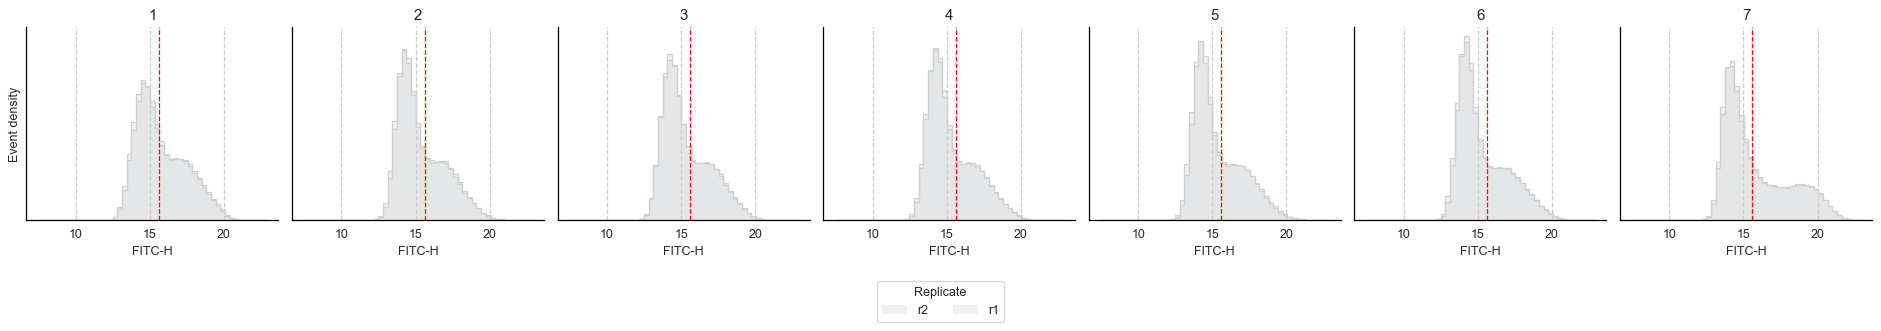

In [10]:
fig, axes = mkeima.plot.channel_distribution(
    data,
    channel=channels["gfp"],
    group_by="Condition",
    hue="Replicate",
)
# Add a GFP cutoff indicator
for ax in axes:
    ax.axvline(np.log2(gfp_cutoff), color="red", ls="--", lw=1)

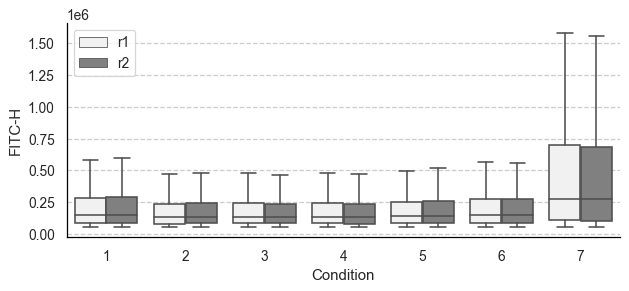

In [11]:
figures = mkeima.plot.replicate_boxplots(
    data[data[channels["gfp"]] > gfp_cutoff],
    channel=channels["gfp"],
    group_by="Condition",
    order=condition_order
)

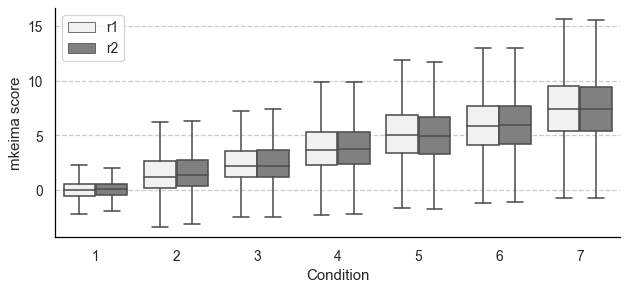

In [12]:
figures = mkeima.plot.replicate_boxplots(
    data[data[channels["gfp"]] > gfp_cutoff],
    channel="mkeima score",
    group_by="Condition",
    order=condition_order
)

## Generate result plots

c:\Users\david.hollenstein\python_venv\licheva-et-al-2024\Lib\site-packages\mkeima\plot.py:435: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
c:\Users\david.hollenstein\python_venv\licheva-et-al-2024\Lib\site-packages\mkeima\plot.py:447: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
meta NOT subset; don't know how to subset; dropped


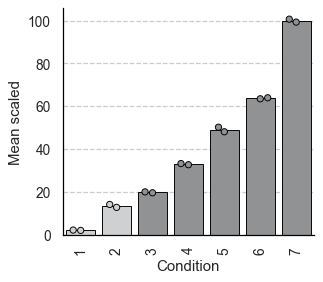

In [13]:
fig, axes = mkeima.plot.replicate_summary(
    summary,
    on="Mean scaled",
    group_by="Condition",
    order=condition_order
)
plt.savefig(figure_path, bbox_inches="tight")

## Export summary

In [14]:
summary.to_csv(summary_path, sep="\t", index=False)